# Tests for Eevent Producer

This notebook will contain some tests to assert that transactional events are produced with the expected patterns, and validate refinements made.

In [2]:
%pip install numpy confluent-kafka matplotlib

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 5.3 MB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 7.8 MB 330 kB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 458 kB/s eta 0:00:01
     |████████████████████████████████| 64 kB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 249 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 2.8 MB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 111 kB 1.4 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
## Non-Uniform Weights of Merchant Categories



In [5]:
# Non-Uniform Weights For Payment Method

import pulse.properties as properties
from pulse.darooghe_pulse import generate_transaction_event
from collections import Counter

NUM_SAMPLES = 50000
TOLERANCE = 0.05

counts = Counter()
for _ in range(NUM_SAMPLES):
    ev = generate_transaction_event()
    counts[ev["payment_method"]] += 1

total = sum(counts.values())

for method, target_weight in properties.PAYMENT_METHOD_WEIGHTS.items():
    observed = counts[method] / total
    assert abs(observed - target_weight) <= TOLERANCE, (
        f"Method {method}: observed {observed:.3f}, target {target_weight:.3f}"
    )

print("Payment method distribution test passed.")


Payment method distribution test passed.


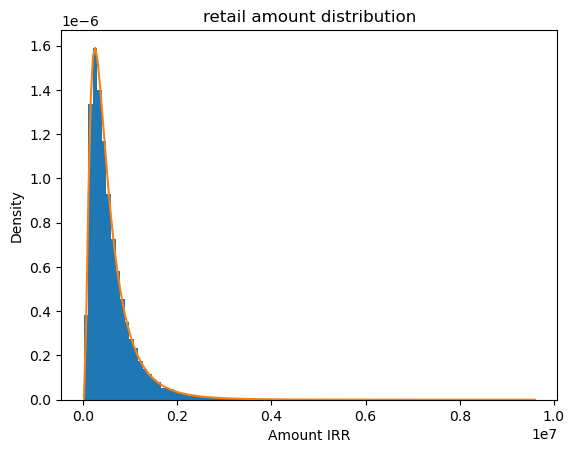

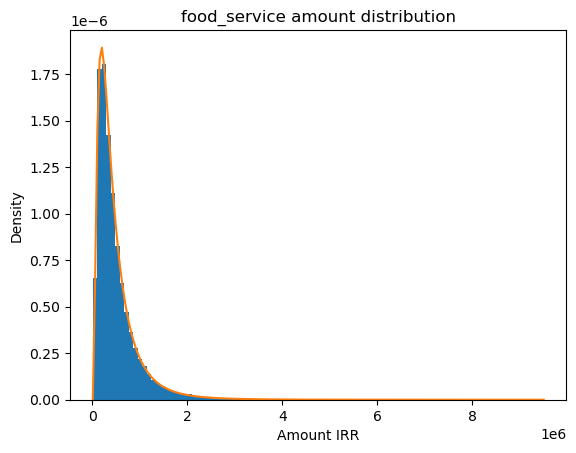

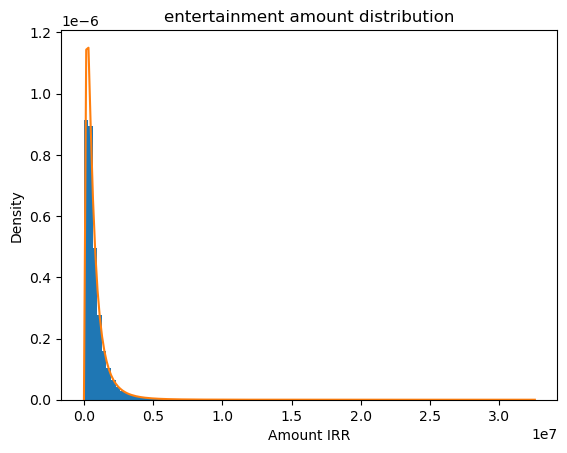

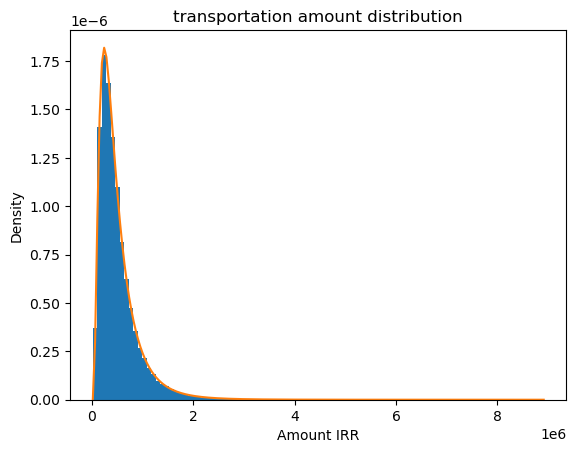

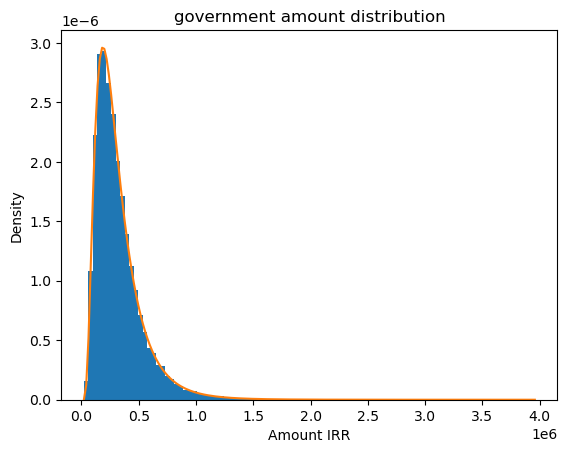

Amount distribution tests passed.


In [1]:
# Log-Normal amount distribution per merchant category

import numpy as np
import math
import pulse.properties as properties
from matplotlib import pyplot as plt

def sample_lognormal(mu, sigma):
    return np.random.lognormal(mean=mu, sigma=sigma)

NUM_SAMPLES = 50000
TOLERANCE = 0.05

for category, params in properties.AMOUNT_DISTRIBUTION_PARAMS.items():
    mu = params["mu"]
    sigma = params["sigma"]

    samples = np.array([sample_lognormal(mu, sigma) for _ in range(NUM_SAMPLES)])

    observed_mean = samples.mean()
    observed_median = np.median(samples)

    theoretical_mean = math.exp(mu + sigma**2 / 2)
    theoretical_median = math.exp(mu)

    # assert within tolerance
    assert abs(observed_mean - theoretical_mean) / theoretical_mean < TOLERANCE, \
        f"Mean mismatch for {category}: observed {observed_mean:.1f}, target {theoretical_mean:.1f}"
    assert abs(observed_median - theoretical_median) / theoretical_median < TOLERANCE, \
        f"Median mismatch for {category}: observed {observed_median:.1f}, target {theoretical_median:.1f}"

    # Extra work: plot histogram and PDF
    plt.figure()
    plt.hist(samples, bins=100, density=True)
    xs = np.linspace(samples.min(), samples.max(), 200)
    pdf = (1/(xs * sigma * math.sqrt(2 * math.pi))) * np.exp(- (np.log(xs) - mu)**2 / (2 * sigma**2))
    plt.plot(xs, pdf)
    plt.title(f"{category} amount distribution")
    plt.xlabel("Amount IRR")
    plt.ylabel("Density")
    plt.show()

print("Amount distribution tests passed.")
